# Case 3. 
Matias Olkkonen<br>
11.03.2018<br>
Cognitive Systems for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences]<br>

# 1. Objectives

The aim of this assignment is to learn to use recurrent and 1D convolutional neural networks to
categorize medical texts.

## Processing raw data
Based on listing 6.8 (p. 189) Chollet: Deep Learning with Python, 2018.

In [46]:
import os

ohsumed_dir = 'ohsumed-first-20000-docs/'
train_dir = os.path.join(ohsumed_dir, 'training')

labels = []
texts = []

# Generate a list L = ['C01', 'C02, ..., 'C023']
L = ['C{:02}'.format(n) for n in range(1, 23 + 1)]
for label_type in L:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()
        i = L.index(label_type)
        labels.append(i)

## Tokenize the text of the raw data
Based on listing 6.9 (p. 189)

In [47]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 300
max_words = 20000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 30857 unique tokens


### Shape the data and labels

In [48]:
from keras.utils.np_utils import to_categorical

data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
one_hot_labels = to_categorical(labels)


print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', one_hot_labels.shape)

Shape of data tensor: (10433, 300)
Shape of labels tensor: (10433, 23)


### Shuffle the data and labels

In [49]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
one_hot_labels = one_hot_labels[indices]

## Build the model
Listing 6.7 (p. 187)

In [50]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(max_words, 100, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(len(L), activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 100)          2000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              30721024  
_________________________________________________________________
dense_11 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_12 (Dense)             (None, 23)                5911      
Total params: 32,989,335
Trainable params: 32,989,335
Non-trainable params: 0
_________________________________________________________________


## Train the model

I tried multiple times different epochs and batch sizes. Accuracy was quite "good" in some cases but getting good result from validation accuracy was quite difficult. Here is some results that I got:


model.add(Embedding(max_words, 8, input_length=maxlen))<br>
epochs = 10,<br>
batch_size = 32, <br>
-> with these values I got accuracy 0.55 and validation accuracy 0.12<br>

model.add(Embedding(max_words, 32, input_length=maxlen))<br>
epochs = 10,<br>
batch_size = 50, <br>
-> with these values I got accuracy 0.5867 and validation accuracy 0.1476<br>


model.add(Embedding(max_words, 50, input_length=maxlen))<br>
epochs = 10,<br>
batch_size = 65,<br> 
-> with these values I got accuracy 0.5664 and validation accuracy 0.1505<br>


model.add(Embedding(max_words, 100, input_length=maxlen))<br>
epochs = 15,<br>
batch_size = 55,<br> 
-> with these values I got accuracy 0.6068 and validation accuracy 0.1145<br>

In [51]:
import time

t1 = time.time()
history = model.fit(data, one_hot_labels,
                   epochs = 15,
                   batch_size = 55,
                   validation_split = 0.2)
t2 = time.time()
print('Elapsed time: {:.2f} seconds'.format((t2-t1)))

Train on 8346 samples, validate on 2087 samples
Epoch 1/15
8346/8346 [==============================] - 194s 23ms/step - loss: 2.8129 - acc: 0.1834 - val_loss: 2.6551 - val_acc: 0.2080
Epoch 2/15
8346/8346 [==============================] - 192s 23ms/step - loss: 2.1661 - acc: 0.3263 - val_loss: 2.7941 - val_acc: 0.1634
Epoch 3/15
8346/8346 [==============================] - 209s 25ms/step - loss: 1.4830 - acc: 0.4958 - val_loss: 3.1442 - val_acc: 0.1390
Epoch 4/15
8346/8346 [==============================] - 253s 30ms/step - loss: 1.1197 - acc: 0.5308 - val_loss: 3.5208 - val_acc: 0.1567
Epoch 5/15
8346/8346 [==============================] - 191s 23ms/step - loss: 0.9164 - acc: 0.5419 - val_loss: 4.2910 - val_acc: 0.1433
Epoch 6/15
8346/8346 [==============================] - 204s 24ms/step - loss: 0.8093 - acc: 0.5497 - val_loss: 4.8198 - val_acc: 0.1509
Epoch 7/15
8346/8346 [==============================] - 311s 37ms/step - loss: 0.7524 - acc: 0.5648 - val_loss: 5.1453 - val_acc: 

## Training results

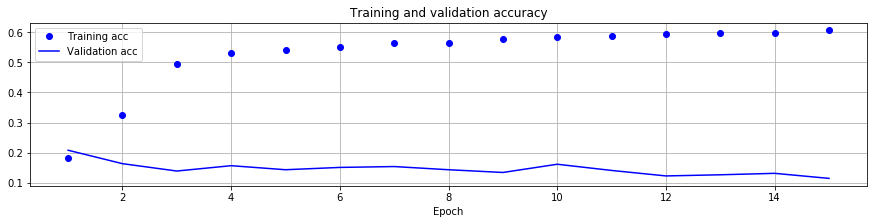

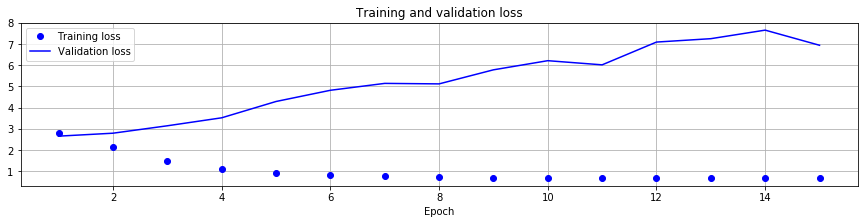

In [53]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 3))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.legend()


plt.figure(figsize=(15, 3))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid()
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Metrics results

In [54]:
# Calculate the predictions
predictions = model.predict(data)
y_pred = np.argmax(predictions, axis = 1)

In [55]:
# http://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score

In [56]:
# Classification results per class
print(classification_report(labels, y_pred))

             precision    recall  f1-score   support

          0       0.56      0.45      0.50       423
          1       0.36      0.42      0.39       158
          2       0.58      0.29      0.39        65
          3       0.62      0.61      0.62      1163
          4       0.38      0.65      0.48       283
          5       0.71      0.34      0.46       588
          6       0.47      0.63      0.54       100
          7       0.54      0.45      0.49       473
          8       0.60      0.51      0.55       125
          9       0.49      0.71      0.58       621
         10       0.49      0.62      0.54       162
         11       0.63      0.42      0.50       491
         12       0.46      0.73      0.57       281
         13       0.59      0.82      0.68      1249
         14       0.61      0.31      0.41       215
         15       0.55      0.62      0.59       200
         16       0.63      0.44      0.52       295
         17       0.78      0.48      0.59   

In [57]:
# Confusion matrix
cm = confusion_matrix(labels, y_pred)
print(np.array2string(cm, max_line_width = 100))

[[ 189    8    0    5   28    8    4   16    0   21    7    4   17   24    6    2    4    2    1
    25   25    3   24]
 [  10   67    0    6    2    4    3    4    1    7    4    0   10    3    1    0    1    0    1
    25    2    0    7]
 [   2    3   19    4    1    1    0    5    0    5    3    0    1    3    0    1    2    0    1
     5    3    0    6]
 [   9   10    1  712   23    5   17   24   14   45    7   28   41   31    5   12   10    8   23
    40   17    4   77]
 [   1    2    0    4  185    1    3    3    0   27    4    1    1    7    0    5    4    1    1
     6   16    0   11]
 [  25    7    1   55   12  199    1    6    0   16    4    9   11   31    3    4    4    6    8
    23   28    7  128]
 [   1    2    0   10    6    0   63    1    0    1    0    1    2    2    0    1    1    2    0
     4    2    0    1]
 [  17   13    0   40    7    3    3  211    4   16    2    2    7   42    3    5    2    0    2
    45   17    5   27]
 [   3    2    0   11    5    0    1   1

In [58]:
print(texts[indices[512]])

Pharmacological reversibility of experimental cerebral vasospasm.
 Using a morphometric technique, the pharmacological reversibility of luminal narrowing after experimental subarachnoid hemorrhage (SAH) was investigated.
 For vasodilation, a "cocktail" consisting of 10(-4) M papaverine, 2 x 10(-4) M sodium nitroprusside, and 10(-5) M adenosine was administered intra-arterially.
 Forty-two rabbits were divided into six groups: control (normal animals); control plus cocktail (normal animals perfused with the cocktail before fixation); SAH (animals sacrificed 48 hours subsequent to intracisternal injection of 1.5 ml/kg of arterial blood); SAH plus cocktail (SAH plus perfusion with the cocktail); BaCl2 (animals sacrificed 10 minutes after intracisternal injection of 2 ml of 3 x 10(-3) M BaCl2); and BaCl2 plus cocktail (BaCl2 animals perfused with the cocktail).
 The diameter of the basilar arteries in the control and the control plus cocktail groups was not significantly different.
 BaCl2 

True class:  13
Predicted class: 13
Predictions per class:
[  2.22e-14   1.58e-21   3.54e-23   1.02e-15   1.28e-12   1.60e-14
   3.54e-25   7.38e-12   2.55e-29   1.87e-10   4.04e-20   3.70e-11
   9.73e-16   1.00e+00   1.79e-17   2.68e-12   4.04e-16   1.77e-12
   1.00e-13   1.17e-17   1.36e-10   2.32e-13   3.51e-10]


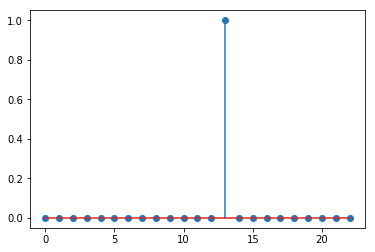

In [59]:
print('True class: ', labels[512])
print('Predicted class:', y_pred[512])
print('Predictions per class:')
print(np.array2string(predictions[512], precision = 2))

plt.stem(predictions[512])
plt.show()

# Conclusions

As we saw it was quite hard, almost impossible to get good accuracy from this data.

In [60]:
np.__version__

'1.12.1'